In [1]:
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
with open('apikey.yml','r') as f:
    secret = yaml.load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

<ipython-input-2-529d706876af>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  secret = yaml.load(f.read())


In [3]:
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

President Trump is trying to put a positive spin on Democratic nominee Joe Biden’s wide fundraising advantage weeks… https://t.co/lSHD81xGrW
Australia's COVID-19 hotspot to partially lift lockdown restrictions https://t.co/XxU5Eq6Yg3 https://t.co/CGRiZtK2Bf
Reeder 5 now provides its own feed service that syncs with iCloud

Bought it the moment I saw this feature because… https://t.co/cHfhSpYKAm
Willowbrook reels as shootings kill three in less than 24 hours https://t.co/jIY1yhW0RU
On average, our model assigns drivers in the 1950s 58% of their teams’ points; today, that share is 19% https://t.co/rVzjmQwk83
At VMI, Black cadets endure lynching threats, Klan memories and Confederacy veneration https://t.co/Zyta8Ho1HV
MOTChallenge: A Benchmark for Single-camera Multiple Target Tracking. https://t.co/MzJwM2wm4d https://t.co/cFfMAwctuP
No Supporters' Shield in 2020, league says https://t.co/0pR3Wn9NEj https://t.co/XXA0FkPJAt
In an already strange year for Broadway, theatrical veteran Aaron 

In [4]:
user = api.get_user('twitter')

In [5]:
dir(user)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api',
 '_json',
 'contributors_enabled',
 'created_at',
 'default_profile',
 'default_profile_image',
 'description',
 'entities',
 'favourites_count',
 'follow',
 'follow_request_sent',
 'followers',
 'followers_count',
 'followers_ids',
 'following',
 'friends',
 'friends_count',
 'geo_enabled',
 'has_extended_profile',
 'id',
 'id_str',
 'is_translation_enabled',
 'is_translator',
 'lang',
 'listed_count',
 'lists',
 'lists_memberships',
 'lists_subscriptions',
 'location',
 'name',
 'notifications',
 'parse',
 'parse_list',
 'profile_background_color',
 'profile_background_image_url',
 'profile_back

In [6]:
import os
import tempfile
import imageio
import requests

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        with open(filepath,'wb') as f:
            f.write(response.content)
        image=imageio.imread(filepath)
        return image
        
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

In [8]:
# https://twitter.com/CaitlinLong_/status/1297937830698655744
# @CaitlinLong_
# @APompliano

Caitlin Long 🔑 CaitlinLong_ True Founder/CEO @AvantiBT. #bitcoin since 2012. GovGordon appointee to Wyoming #Blockchain Select Committee. 22-yr Wall St veteran. Not advice;not views of Avanti!
(48, 48, 3)


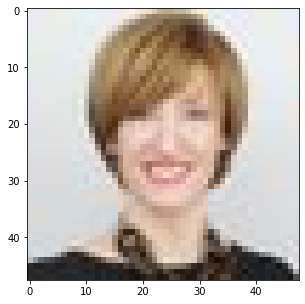

In [9]:
user,profile_image = get_user_info('@CaitlinLong_')

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

Polina Marinova Pompliano polina_marinova True Studying the world's most interesting people & companies. Founder & author of @ProfileRead at https://t.co/v2ZdSQv5wg // former writer at @fortunemagazine
(48, 48, 3)


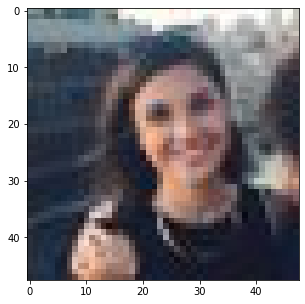

In [10]:
user,profile_image = get_user_info('@polina_marinova')

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

Pomp 🌪 APompliano True Co-founder at Morgan Creek Digital. I host a top 10 podcast in finance & technology and write a daily letter to 80k investors: https://t.co/t2l8wvaYRM
(48, 48, 3)


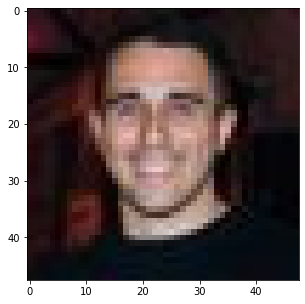

In [11]:
user,profile_image = get_user_info('@APompliano')

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

Elon Musk elonmusk True 
(48, 48, 3)


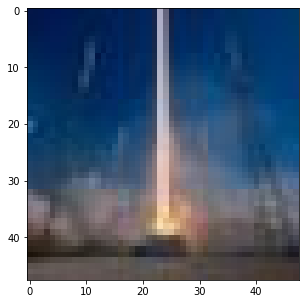

In [12]:
user,profile_image = get_user_info('@elonmusk')

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

source_image = np.copy(profile_image)

In [13]:
search_phrase = user.name

In [14]:
import traceback
#from tqdm.notebook import tqdm
fetch = []
count = 20
try:
    for x in range(50):
        tmp = api.search_users(search_phrase,count,page=x)
        fetch.extend(tmp)
        if len(tmp)<count:
            break
except:
    traceback.print_exc()
    
newfetch = []
for x in fetch:
    if x.screen_name not in [x.screen_name for x in newfetch]:
        newfetch.append(x)
fetch = newfetch
print(len(fetch))

980


In [20]:
# try to find a match based on profile image
mylist = []
for x in tqdm(fetch):
    try:
        user,profile_image = get_user_info(x.screen_name)
        if profile_image.shape[2] > 3:
            profile_image = profile_image[:,:,:3]
        item = dict(name=user.screen_name,mean_diff=np.mean(profile_image-source_image))
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 232, in execute
    raise RateLimitError(error_msg, resp)
tweepy.error.RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]
Traceback (most recent call last):
  File "<ipython-input-20-a962b5e0bc23>", line 5, in <module>
    user,profile_image = get_user_info(x.screen_name)
  File "<ipython-input-7-0c355fe3e1af>", line 2, in get_user_info
    user = api.get_user(screen_name)
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binder.py", line 252, in _call
    return method.execute()
  File "/usr/local/lib/python3.8/dist-packages/tweepy/binde

In [22]:
df.shape

(197, 2)

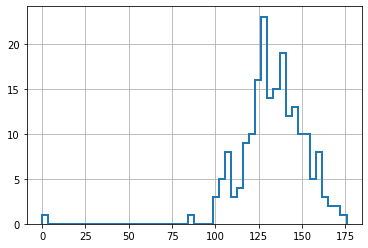

In [24]:
_=plt.hist(df.mean_diff,bins=50,histtype='step',linewidth=2)
plt.grid(True)